In [1]:
import sys
sys.executable

'c:\\Users\\Asus\\AppData\\Local\\Programs\\Python\\Python312\\python.exe'

In [2]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sentiment = pd.read_csv("data/fear_greed_index.csv")
trades = pd.read_csv("data/historical_data.csv")

sentiment.head(), trades.head()

(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

In [5]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    format='%d-%m-%Y %H:%M'
)

trades['date'] = trades['Timestamp IST'].dt.date

trades[['Timestamp IST', 'date']].head()

,Timestamp IST,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [6]:
sentiment['sentiment_group'] = sentiment['classification'].replace({
    'Extreme Fear': 'Fear',
    'Extreme Greed': 'Greed'
})

In [7]:
sentiment[['classification', 'sentiment_group']].value_counts()

classification  sentiment_group
Fear            Fear               781
Greed           Greed              633
Extreme Fear    Fear               508
Neutral         Neutral            396
Extreme Greed   Greed              326
Name: count, dtype: int64

In [8]:
merged = trades.merge(
    sentiment[['date', 'sentiment_group']],
    on='date',
    how='left'
)

merged.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,sentiment_group
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,NaN


In [9]:
daily_pnl = (
    merged
    .groupby(['Account', 'date', 'sentiment_group'])['Closed PnL']
    .sum()
    .reset_index()
)

merged['win'] = merged['Closed PnL'] > 0

win_rate = (
    merged
    .groupby(['Account', 'sentiment_group'])['win']
    .mean()
    .reset_index(name='win_rate')
)

trades_per_day = (
    merged
    .groupby(['date', 'sentiment_group'])
    .size()
    .reset_index(name='num_trades')
)

In [10]:
daily_pnl.shape, daily_pnl.head()

((0, 4),
 Empty DataFrame
 Columns: [Account, date, sentiment_group, Closed PnL]
 Index: [])

In [11]:
daily_pnl.shape

(0, 4)

In [12]:
daily_pnl['sentiment_group'].value_counts(dropna=False)

Series([], Name: count, dtype: int64)

In [13]:
daily_pnl = daily_pnl.dropna(subset=['sentiment_group'])

In [14]:
daily_pnl['Closed PnL'].dtype

dtype('float64')

In [15]:
daily_pnl['sentiment_group'].unique()

<StringArray>
[]
Length: 0, dtype: str

In [16]:
merged.shape


(211224, 19)

In [17]:
merged['sentiment_group'].value_counts(dropna=False)

sentiment_group
NaN    211224
Name: count, dtype: int64

In [18]:
# Convert BOTH to pandas datetime (not .dt.date)
sentiment['date_dt'] = pd.to_datetime(sentiment['date'])
trades['date_dt'] = pd.to_datetime(trades['Timestamp IST']).dt.normalize()

In [19]:
sentiment['date_dt'].dtype, trades['date_dt'].dtype

(dtype('<M8[us]'), dtype('<M8[us]'))

In [20]:
merged = trades.merge(
    sentiment[['date_dt', 'sentiment_group']],
    on='date_dt',
    how='inner'
)

merged.shape

(211218, 19)

In [21]:
merged['sentiment_group'].value_counts()

sentiment_group
Greed      90295
Fear       83237
Neutral    37686
Name: count, dtype: int64

In [22]:
daily_pnl = (
    merged
    .groupby(['Account', 'date_dt', 'sentiment_group'])['Closed PnL']
    .sum()
    .reset_index()
)

daily_pnl.shape

(2340, 4)

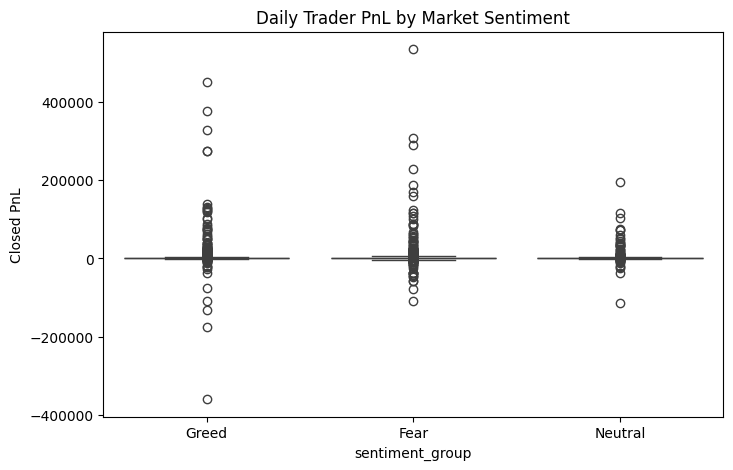

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=daily_pnl,
    x='sentiment_group',
    y='Closed PnL'
)
plt.title("Daily Trader PnL by Market Sentiment")
plt.show()

In [24]:
print("Sentiment date range:", sentiment['date'].min(), "→", sentiment['date'].max())
print("Trades date range:", trades['date'].min(), "→", trades['date'].max())


Sentiment date range: 2018-02-01 → 2025-05-02
Trades date range: 2023-05-01 → 2025-05-01


In [25]:
# Force sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Force trades date
trades['date'] = pd.to_datetime(trades['date']).dt.date

In [26]:
sentiment['date'].dtype, trades['date'].dtype

(dtype('O'), dtype('O'))

In [27]:
merged = trades.merge(
    sentiment[['date', 'sentiment_group']],
    on='date',
    how='inner'   # use inner to confirm overlap
)

merged.shape

(211218, 19)

In [28]:
daily_pnl = (
    merged
    .groupby(['Account', 'date', 'sentiment_group'])['Closed PnL']
    .sum()
    .reset_index()
)

daily_pnl.shape, daily_pnl.head()

((2340, 4),
                                       Account        date sentiment_group  \
 0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11           Greed   
 1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17           Greed   
 2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18           Greed   
 3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22           Greed   
 4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26           Greed   
 
    Closed PnL  
 0         0.0  
 1         0.0  
 2         0.0  
 3    -21227.0  
 4      1603.1  )

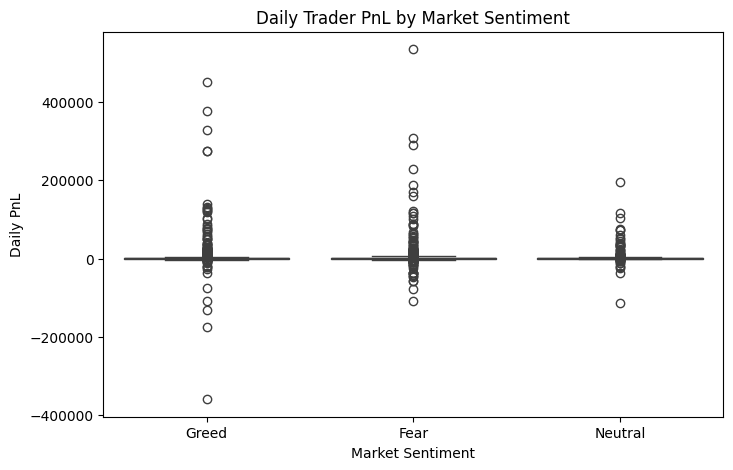

In [29]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=daily_pnl,
    x='sentiment_group',
    y='Closed PnL'
)
plt.title("Daily Trader PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()

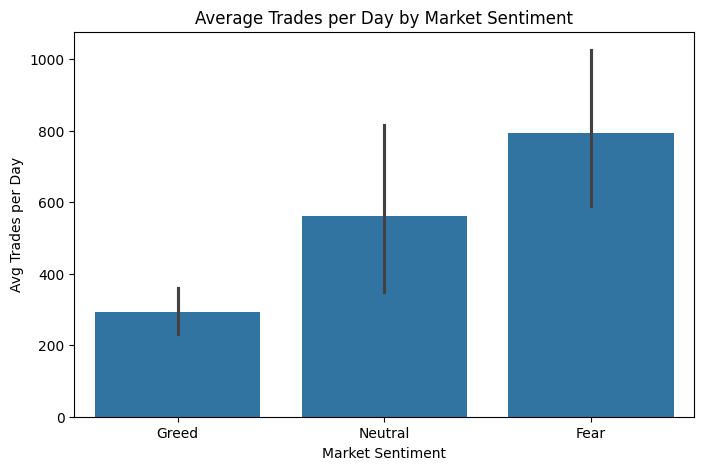

In [30]:
trades_per_day = (
    merged
    .groupby(['date', 'sentiment_group'])
    .size()
    .reset_index(name='num_trades')
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=trades_per_day,
    x='sentiment_group',
    y='num_trades',
    estimator='mean'
)
plt.title("Average Trades per Day by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Avg Trades per Day")
plt.show()

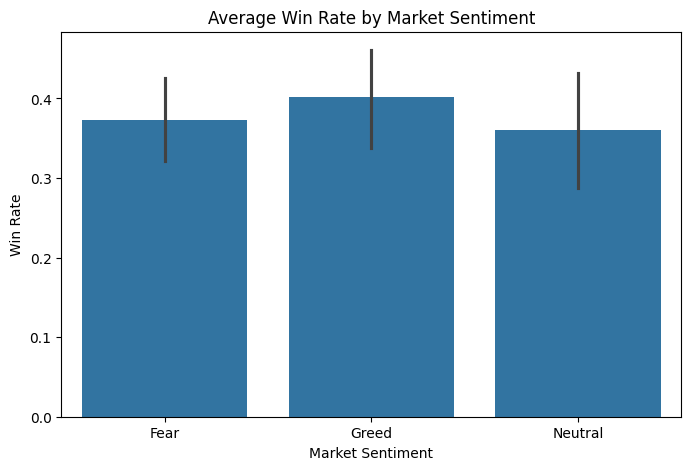

In [31]:
merged['win'] = merged['Closed PnL'] > 0

win_rate = (
    merged
    .groupby(['Account', 'sentiment_group'])['win']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=win_rate,
    x='sentiment_group',
    y='win',
    estimator='mean'
)
plt.title("Average Win Rate by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.show()